In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

Random Forest Test MSE: 0.000080
Random Forest Sharpe Ratio: -0.7922
Random Forest Max Drawdown: -0.2127


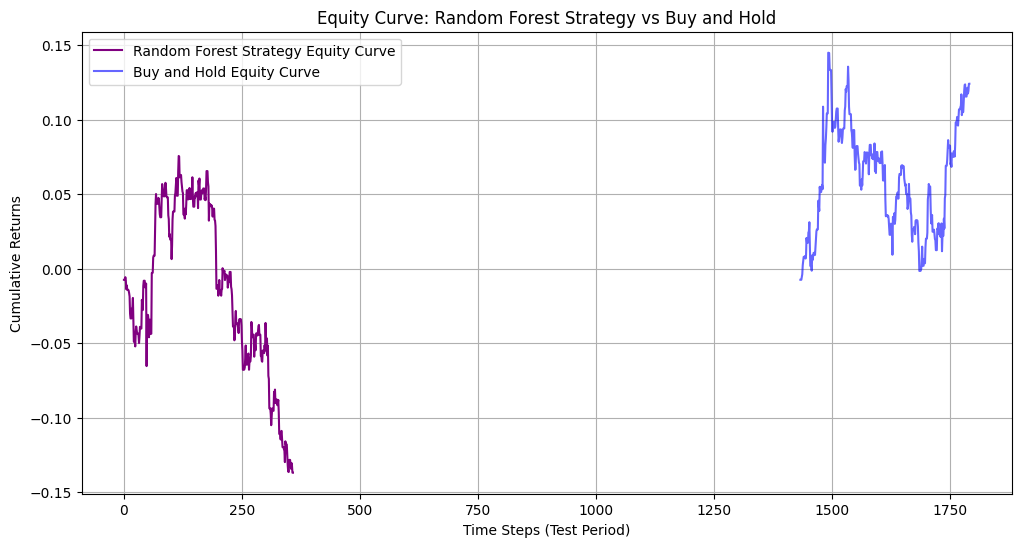

In [8]:
df = pd.read_csv("Preprocessed_Data_with_features.csv")

# Assume df is your preprocessed dataframe with features and target 'Return'
# Features you mentioned earlier:
features = ['SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_signal', 'Bollinger_High', 'Bollinger_Low', 'ATR_14', 'Momentum_10']

X = df[features]
y = df['Return']

# Train-test split (e.g., last 20% data as test)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Initialize and train Random Forest Regressor
rf_model_1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_1.fit(X_train, y_train)

# Predict returns on test set
y_pred = rf_model_1.predict(X_test)

# Calculate Test MSE
test_mse = mean_squared_error(y_test, y_pred)

# Function to calculate Sharpe Ratio
def sharpe_ratio(returns):
    mean_ret = np.mean(returns)
    std_ret = np.std(returns)
    return (mean_ret / std_ret) * np.sqrt(252)

# Calculate strategy returns: long if predicted return > 0, else short
strategy_returns = np.where(y_pred > 0, y_test, -y_test)

# Calculate Sharpe Ratio
sharpe = sharpe_ratio(strategy_returns)

# Calculate Max Drawdown
cumulative_returns = np.cumsum(strategy_returns)
running_max = np.maximum.accumulate(cumulative_returns)
drawdown = cumulative_returns - running_max
max_drawdown = drawdown.min()

print(f"Random Forest Test MSE: {test_mse:.6f}")
print(f"Random Forest Sharpe Ratio: {sharpe:.4f}")
print(f"Random Forest Max Drawdown: {max_drawdown:.4f}")

# Plot equity curve
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Random Forest Strategy Equity Curve', color='purple')
plt.plot(np.cumsum(y_test), label='Buy and Hold Equity Curve', color='blue', alpha=0.6)
plt.title('Equity Curve: Random Forest Strategy vs Buy and Hold')
plt.xlabel('Time Steps (Test Period)')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


**Buy and Hold Strategy**

Equity Curve: Light blue line (right portion of the graph).

Performance:

* Shows clear cumulative growth with fluctuations.

* Reaches a return of about 12-14% by the end of the test period.

Overall Result: Outperforms the Random Forest strategy both in return and stability.

Despite low prediction error, the strategy performed poorly with a steady decline in cumulative returns and high drawdown.

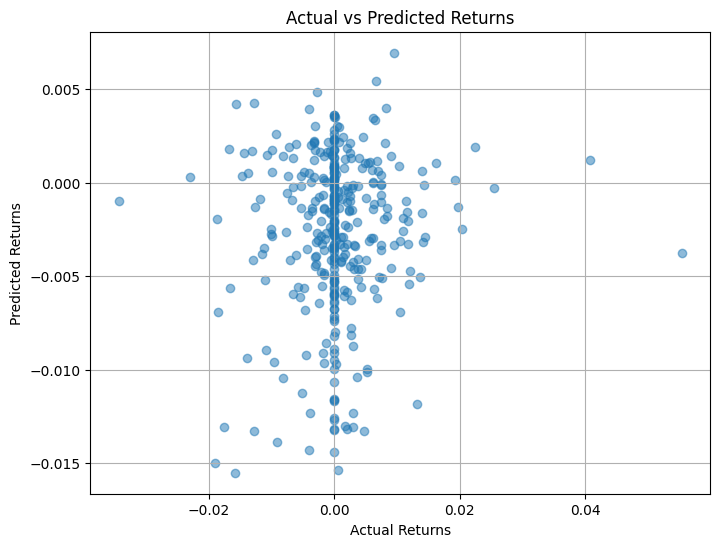

In [9]:
#Prediction accuracy plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Actual vs Predicted Returns')
plt.grid(True)
plt.show()

The plot shows high concentration around (0,0), indicating:

The model predicts most returns close to zero, even when actual returns deviate.

This suggests the model is too conservative, possibly underfitting or over-regularized.

Poor dispersion along the diagonal line (i.e., predicted ≈ actual):

Indicates the model fails to capture the direction and magnitude of larger returns well.

There's weak linear correlation between predictions and actuals.

What This Means
Despite having a better Sharpe Ratio, this pattern shows the model is playing it safe, mostly predicting “no movement,” which happens to reduce risk in your strategy (hence Sharpe improves). But it's not learning the true return structure well.

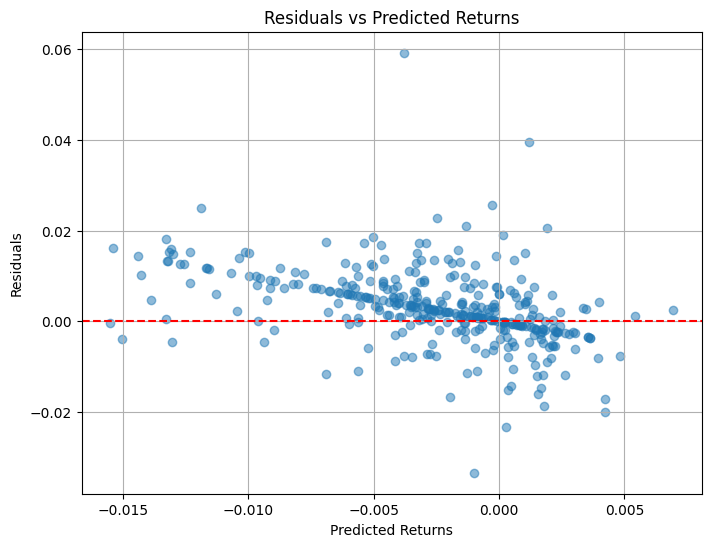

In [10]:
#Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Returns')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Returns')
plt.grid(True)
plt.show()

1. **Non-random Pattern Detected**

There's a visible negative linear trend, where lower predicted returns are associated with larger positive residuals and higher predicted returns with negative residuals.

This is not ideal. It suggests the model may be systematically underestimating high returns and overestimating low (or negative) returns.

2. **Heteroskedasticity**

The spread of residuals appears to narrow as predicted returns approach zero, and widen for more extreme predicted values.

This implies variance is not constant, a sign of heteroskedasticity, which violates assumptions of many regression models and may affect inference quality.

3. **Possible Model Bias**

Ideally, residuals should be randomly scattered around zero. The clear structure in this plot hints that the model may be biased or missing some key features.

## Improved Random Forest Model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
24 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/si

Random Forest Test MSE: 0.000060
Random Forest Sharpe Ratio: 0.1877
Random Forest Max Drawdown: -0.0924


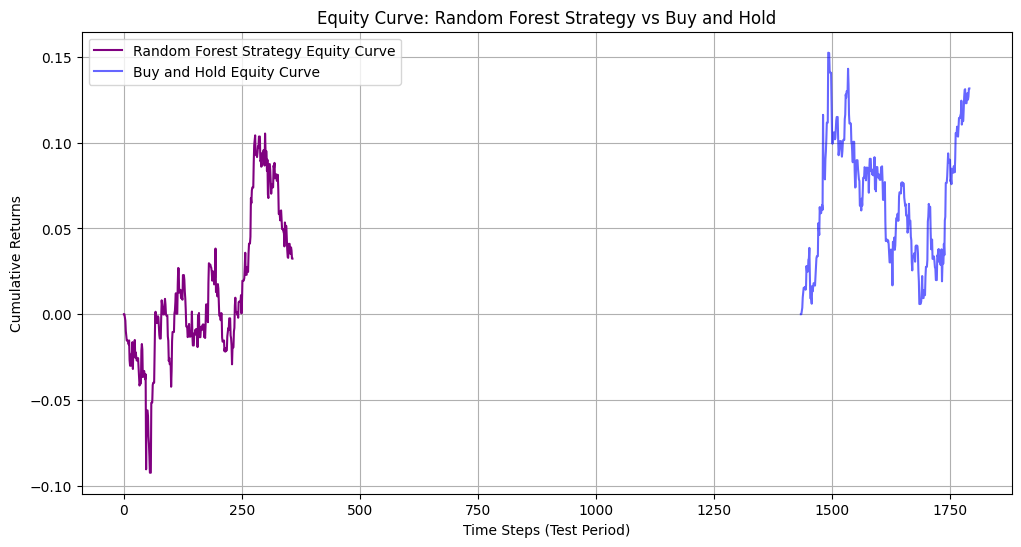

In [11]:
# Add lagged returns (helps capture momentum/reversal)
df['Return_Lag1'] = df['Return'].shift(1)
df['Return_Lag2'] = df['Return'].shift(2)
df = df.dropna()

# Features
features = ['SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_signal',
            'Bollinger_High', 'Bollinger_Low', 'ATR_14', 'Momentum_10',
            'Return_Lag1', 'Return_Lag2']

X = df[features]
y = df['Return']

# Train-test split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# ---------------------------
# Hyperparameter tuning
# ---------------------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                            n_iter=20, cv=3, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')
search.fit(X_train, y_train)

# Best model
rf_model = search.best_estimator_

# Predict returns on test set
y_pred = rf_model.predict(X_test)

# Evaluate
test_mse = mean_squared_error(y_test, y_pred)

def sharpe_ratio(returns):
    mean_ret = np.mean(returns)
    std_ret = np.std(returns)
    return (mean_ret / std_ret) * np.sqrt(252)

strategy_returns = np.where(y_pred > 0, y_test, -y_test)
sharpe = sharpe_ratio(strategy_returns)

# Max Drawdown
cumulative_returns = np.cumsum(strategy_returns)
running_max = np.maximum.accumulate(cumulative_returns)
drawdown = cumulative_returns - running_max
max_drawdown = drawdown.min()

# Print metrics
print(f"Random Forest Test MSE: {test_mse:.6f}")
print(f"Random Forest Sharpe Ratio: {sharpe:.4f}")
print(f"Random Forest Max Drawdown: {max_drawdown:.4f}")

# Plot equity curve
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Random Forest Strategy Equity Curve', color='purple')
plt.plot(np.cumsum(y_test), label='Buy and Hold Equity Curve', color='blue', alpha=0.6)
plt.title('Equity Curve: Random Forest Strategy vs Buy and Hold')
plt.xlabel('Time Steps (Test Period)')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


The model is minimizing MSE well but is not learning strong signal from the features — reflected in the low R² and flat predictions.

In financial prediction, direction classification often works better than raw regression because:

Returns are noisy.

Despite the slightly lower MSE, the **second model** performs much worse in trading terms:

* Sharpe Ratio flips negative, implying the strategy is not just underperforming—it’s actively destroying value.

* Max Drawdown more than doubles, a strong sign of poor risk control.

* The first Random Forest model is clearly superior, both in terms of risk-adjusted returns and capital preservation.

In [12]:
import joblib
joblib.dump(rf_model_1, 'models/Random_Forest_model.pkl')

['models/Random_Forest_model.pkl']